In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers

import numpy as np
from tensorflow import keras

### Initialization

In [2]:
num_classes = 10 # total classes (0-9 digits).

# Training Parameteres
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

#Network Parameters
conv1_filters = 32 # number of filters for teh first conv layer
conv2_filters = 64 # number of filters for second conv layer
fcl_units = 1024   # number of neurons for the fully connected layer


### Prepare Dataset

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

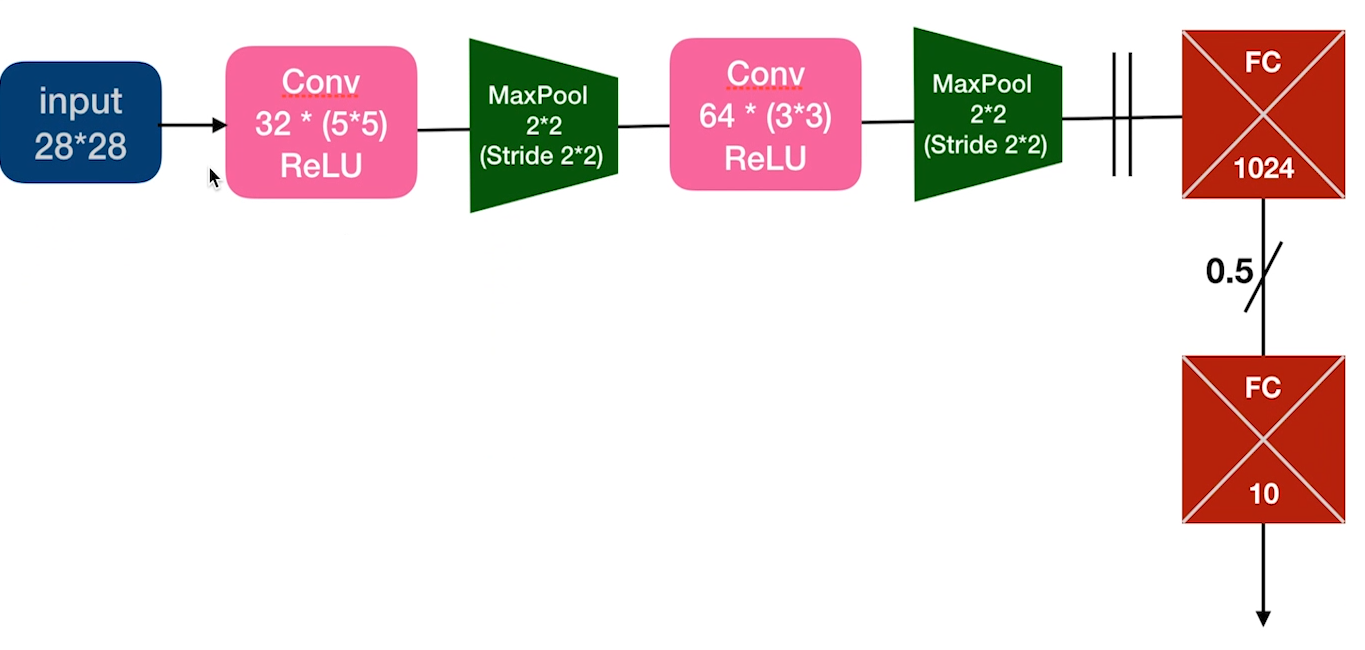

### Create TF Model

In [5]:
class ConvNet(Model):
  # set layers
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = layers.Conv2D(32, kernel_size=5, activation= tf.nn.relu)

    self.maxpool1 = layers.MaxPool2D(2, strides=2)

    self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)

    self.maxpool2= layers.MaxPool2D(2, strides=2)

    self.flatten = layers.Flatten()

    self.fc1 = layers.Dense(1024)

    self.dropout = layers.Dropout(rate = 0.2)

    self.fc2 = layers.Dense(2048)

    self.dropout2 = layers.Dropout(rate= 0.5)

    self.out = layers.Dense(num_classes)

  def call(self, x, is_training=False):
      x = tf.reshape(x, [-1,28,28,1])
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool2(x)
      x = self.flatten(x)
      x = self.fc1(x)

      x = self.dropout(x, training = is_training)
      x = self.fc2(x)
      x = self.dropout2(x, training=is_training)

      x = self.out(x)

      if not is_training:
        x = tf.nn.softmax(x)

      return x


conv_net = ConvNet()

In [6]:
def cross_entropy_loss(x, y):
  y = tf.cast(y, tf.int64)

  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
  return tf.reduce_mean(loss)

def accuracy(y_pred, y_true):
  correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.cast(y_true, tf.int64))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

### Optimization Process

In [7]:
@tf.function
def run_optimization(x, y):
  with tf.GradientTape() as g:
    pred = conv_net(x, is_training=True)
    loss = cross_entropy_loss(pred, y)


  trainable_variables = conv_net.trainable_variables

  gradients = g.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

### Run Training for the given number of steps

In [8]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  run_optimization(batch_x, batch_y)

  if step % display_step == 0:
    pred = conv_net(batch_x)
    loss = cross_entropy_loss(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print("step: %i, loss: %f, accuracy: %f" %(step,loss,acc))

step: 10, loss: 1.708723, accuracy: 0.812500
step: 20, loss: 1.576375, accuracy: 0.914062
step: 30, loss: 1.560591, accuracy: 0.968750
step: 40, loss: 1.552697, accuracy: 0.945312
step: 50, loss: 1.529162, accuracy: 0.968750
step: 60, loss: 1.536817, accuracy: 0.953125
step: 70, loss: 1.503770, accuracy: 0.976562
step: 80, loss: 1.516266, accuracy: 0.968750
step: 90, loss: 1.501310, accuracy: 0.976562
step: 100, loss: 1.512903, accuracy: 0.992188
step: 110, loss: 1.510373, accuracy: 0.984375
step: 120, loss: 1.500093, accuracy: 0.984375
step: 130, loss: 1.497131, accuracy: 0.976562
step: 140, loss: 1.492944, accuracy: 0.984375
step: 150, loss: 1.493134, accuracy: 0.976562
step: 160, loss: 1.480155, accuracy: 0.992188
step: 170, loss: 1.477126, accuracy: 0.992188
step: 180, loss: 1.484315, accuracy: 0.984375
step: 190, loss: 1.494797, accuracy: 0.968750
step: 200, loss: 1.495648, accuracy: 0.968750


In [9]:
pred = conv_net(x_test)

print("Test Accuracy: %f" % accuracy(pred,y_test))

Test Accuracy: 0.979500
